# Train a field of study (domain) classification of sentences on the [MAG](https://github.com/allenai/scibert/tree/master/data/text_classification/mag) dataset

[SciBERT achieves an F1-score of 0.6571 on this dataset.](https://paperswithcode.com/sota/sentence-classification-on-paper-field) 
This notebook shows that better results can be achieved without even using transformers.

In [1]:
import json
from typing import Tuple
from great_ai.utilities import clean, parallel_map
from tqdm.cli import tqdm


def preprocess(line: str) -> Tuple[str, str]:
    data_point = json.loads(line)

    return (clean(data_point["text"], convert_to_ascii=True), data_point["label"])


with open("mag/train.txt", encoding="utf-8") as f:
    training_data = list(tqdm(parallel_map(preprocess, f.readlines())))

X_train = [d[0] for d in training_data]
y_train = [d[1] for d in training_data]


with open("mag/test.txt", encoding="utf-8") as f:
    test_data = list(tqdm(parallel_map(preprocess, f.readlines())))

X_test = [d[0] for d in test_data]
y_test = [d[1] for d in test_data]

84000it [00:09, 8647.60it/s] 
22399it [00:03, 6368.63it/s]


In [2]:
import pandas as pd
from collections import Counter
import plotly.express as px


df = pd.DataFrame(Counter(y_train).most_common(), columns=["domain", "count"])
px.bar(df, "domain", "count", width=1200, height=400).show()

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


def create_pipeline() -> Pipeline:
    return Pipeline(
        steps=[
            ("vectorizer", TfidfVectorizer(sublinear_tf=True)),
            ("classifier", MultinomialNB()),
        ]
    )

In [4]:
from sklearn.model_selection import GridSearchCV

optimisation_pipeline = GridSearchCV(
    create_pipeline(),
    {
        "vectorizer__min_df": [5, 20, 100],
        "vectorizer__max_df": [0.05, 0.1],
        "classifier__alpha": [0.5, 1],
        "classifier__fit_prior": [True, False],
    },
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1,
)
optimisation_pipeline.fit(X_train, y_train)

results = pd.DataFrame(optimisation_pipeline.cv_results_)
results.sort_values("rank_test_score")

Fitting 3 folds for each of 24 candidates, totalling 72 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__fit_prior,param_vectorizer__max_df,param_vectorizer__min_df,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,1.227354,0.011710,0.652844,0.040511,1,True,0.05,5,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.677283,0.670398,0.665671,0.671118,0.004768,1
15,1.279783,0.037969,0.634761,0.068606,1,True,0.1,5,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.676970,0.670244,0.666123,0.671112,0.004470,2
18,1.332854,0.171405,0.743611,0.109792,1,False,0.05,5,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.675678,0.669321,0.665305,0.670101,0.004271,3
21,1.253222,0.072134,0.612344,0.016771,1,False,0.1,5,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.675569,0.669482,0.665225,0.670092,0.004245,4
3,1.472035,0.080849,0.654935,0.044302,0.5,True,0.1,5,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.675225,0.668912,0.665652,0.669930,0.003974,5
0,1.380641,0.054306,0.739966,0.053385,0.5,True,0.05,5,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.675264,0.668781,0.665394,0.669813,0.004095,6
9,1.284987,0.113903,0.696876,0.003757,0.5,False,0.1,5,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.674199,0.668005,0.664456,0.668887,0.004026,7
6,1.291148,0.101837,0.686561,0.083989,0.5,False,0.05,5,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.673996,0.668048,0.664572,0.668872,0.003891,8
13,1.268873,0.042412,0.645649,0.022738,1,True,0.05,20,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.656459,0.647433,0.644864,0.649585,0.004972,9
16,1.147120,0.009335,0.599006,0.045637,1,True,0.1,20,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.656196,0.646960,0.645436,0.649530,0.004754,10


In [5]:
from sklearn import set_config

set_config(display="diagram")

classifier = create_pipeline()
classifier.set_params(**optimisation_pipeline.best_params_)
classifier.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.05, min_df=5, sublinear_tf=True)),
                ('classifier', MultinomialNB(alpha=1))])

              precision    recall  f1-score   support

    business     0.6412    0.7258    0.6808      3198
   economics     0.6635    0.7146    0.6881      3189
   geography     0.7461    0.6791    0.7111      3207
    medicine     0.8806    0.9021    0.8912      3187
    politics     0.5563    0.5895    0.5724      3169
  psychology     0.7654    0.6811    0.7208      3252
   sociology     0.5165    0.4698    0.4921      3197

    accuracy                         0.6803     22399
   macro avg     0.6814    0.6803    0.6795     22399
weighted avg     0.6817    0.6803    0.6796     22399



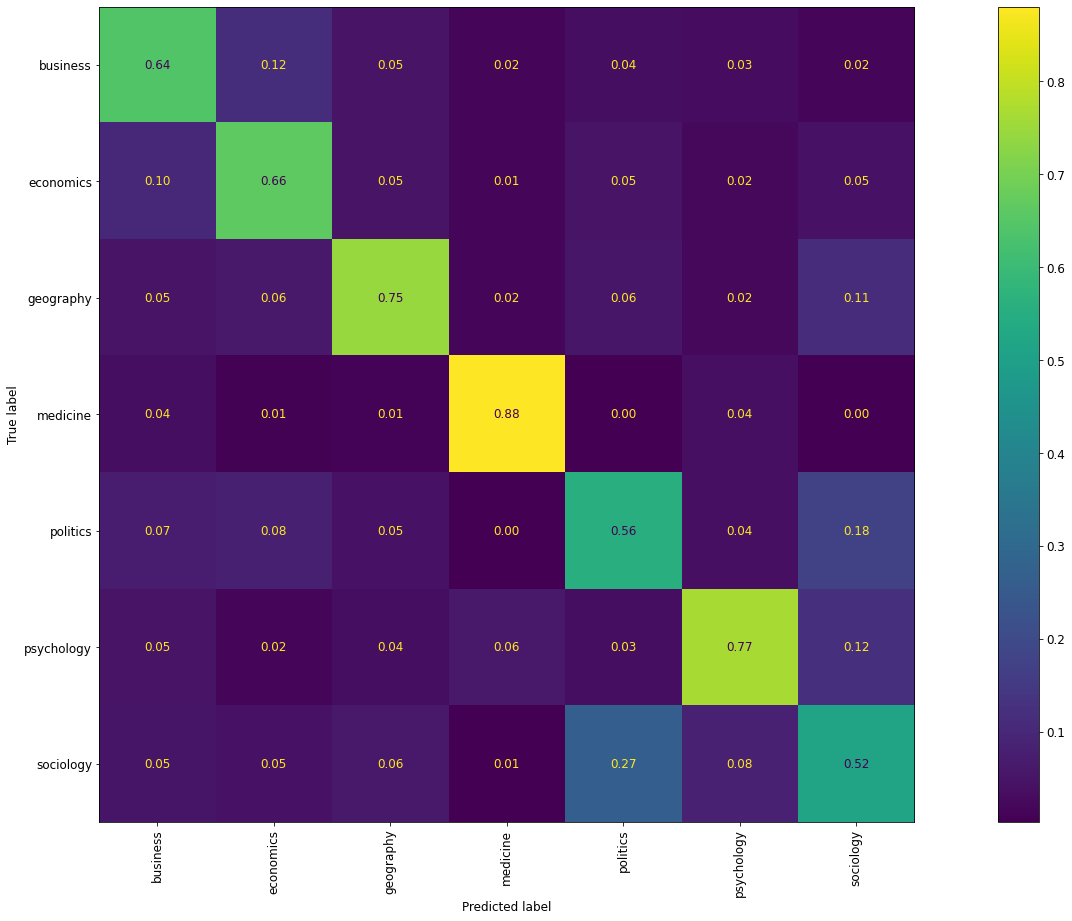

In [6]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_predicted = classifier.predict(X_test)

%matplotlib inline
plt.rcParams["figure.figsize"] = (30, 15)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.xmargin"] = 0

print(metrics.classification_report(y_test, y_predicted, digits=4))
metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_predicted,
    xticks_rotation="vertical",
    normalize="pred",
    values_format=".2f",
)
None